## Ford Gobike Data Exploration


In [77]:
#Importing required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
%matplotlib inline
pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore")


In [78]:
# Read csv files into a pandas dataframe
df_bike = pd.read_csv("201902-fordgobike-tripdata.csv")
#display first 5 rows in dataset
df_bike.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [79]:
#select the most interesting columns from dataset
interesting_columns = [
    'duration_sec', 'start_time', 'end_time',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'user_type',
       'member_birth_year', 'member_gender', 'bike_share_for_all_trip'
]
df_bike = pd.DataFrame(df_bike, columns=interesting_columns)

In [80]:
#check the dataset features types and shape
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_name       183215 non-null  object 
 4   start_station_latitude   183412 non-null  float64
 5   start_station_longitude  183412 non-null  float64
 6   end_station_name         183215 non-null  object 
 7   end_station_latitude     183412 non-null  float64
 8   end_station_longitude    183412 non-null  float64
 9   user_type                183412 non-null  object 
 10  member_birth_year        175147 non-null  float64
 11  member_gender            175147 non-null  object 
 12  bike_share_for_all_trip  183412 non-null  object 
dtypes: float64(5), int64(1), object(7)
memory usage: 18.2+ MB


From dataset info, we can see that:
1. Dataset shape (183412,13)
3. Based on (`start_station_latitude`,`start_station_longitude`) and (`end_station_latitude`,`end_station_latitude`) we can extract distance feature to help at analysis
4. `member_birth_year`, `member_gender`, `start_station_name` and `end_station_name` have missing values
5. `start_time` and `end_time` saved as an object, will convert it to DateTime type to extract new time features

In [81]:
#check percentage of missing values in columns
for column in df_bike:
    if df_bike[column].isnull().any():
        print(f'{column}: {100*(df_bike[column].isnull().sum() / len(df_bike[column])):.4f}%')

start_station_name: 0.1074%
end_station_name: 0.1074%
member_birth_year: 4.5062%
member_gender: 4.5062%


##### - based on percentage the same rows of missing values are the same in (start_station_name , end_station_name) and (member_birth_year , member_gender) 

In [82]:
#drop missing values
df_bike.dropna(axis=0 , inplace=True)

In [83]:
# Number of unique values in Features 
df_bike.nunique()

duration_sec                 4429
start_time                 174941
end_time                   174939
start_station_name            329
start_station_latitude        329
start_station_longitude       329
end_station_name              329
end_station_latitude          329
end_station_longitude         329
user_type                       2
member_birth_year              75
member_gender                   3
bike_share_for_all_trip         2
dtype: int64

In [84]:
#check the values and its percentage in categorical columns
for column in df_bike[['user_type' , 'member_gender' , 'bike_share_for_all_trip']]:
    print(f'{column}:\n{df_bike[column].value_counts(normalize=True)}')

user_type:
Subscriber    0.905311
Customer      0.094689
Name: user_type, dtype: float64
member_gender:
Male      0.745919
Female    0.233235
Other     0.020846
Name: member_gender, dtype: float64
bike_share_for_all_trip:
No     0.900853
Yes    0.099147
Name: bike_share_for_all_trip, dtype: float64


In [85]:
#Any duplicated rows ?
df_bike.duplicated().sum()

0

In [86]:
def Get_Distance(start_latitude, start_longitude, end_latitude, end_longitude):
    '''extract trip distance bease on longitude and latitude features
    return: distance in km'''
    coords_1 = (start_latitude, start_longitude)
    coords_2 = (end_latitude, end_longitude)
    return geodesic(coords_1, coords_2).km

In [87]:
#Add distance feature
df_bike['distance_km'] = df_bike.apply(lambda x: Get_Distance(x['start_station_latitude'], x['start_station_longitude'],
                                                           x['end_station_latitude'], x['end_station_longitude']), axis=1) 
#convert member_birth_year to ages and duration from sec to min for analysis
df_bike['member_age'] = (2021 - df_bike['member_birth_year']).astype('Int64')
#convert duration_sec to duration_min
df_bike['duration_min'] = (df_bike['duration_sec']/60).astype('int')

In [88]:
#change type of time data from object to datetime to extract features
df_bike[['start_time' , 'end_time']] = df_bike[['start_time' , 'end_time']].apply(pd.to_datetime).values.astype('<M8[m]')
#create column fot trip date
df_bike['trip_date'] = df_bike['start_time'].dt.date
#create column fot trip time
df_bike['trip_time']=df_bike['start_time'].dt.time
#create column fot trip day
df_bike['trip_day'] = df_bike['start_time'].dt.day_name()
#extract start hour from start_time column to add day parts feature
df_bike['start_time_hour'] = df_bike['start_time'].dt.hour
df_bike['day_part_of_trip'] = pd.cut(df_bike['start_time_hour'], bins=[0,5,11,16,23], labels=['Night', 'Morning','Afternoon','Evening'], include_lowest=True)

In [89]:
#drop not useful column in analysis
df_bike.drop(['member_birth_year','duration_sec','start_station_latitude', 
                                 'start_station_longitude' , 'end_station_latitude','end_station_longitude','start_time_hour'],axis=1,inplace=True)

In [90]:
#check the time period of dataset
print(df_bike.start_time.min() , df_bike.end_time.max())

2019-02-01 00:00:00 2019-03-01 08:01:00


In [91]:
#descriptive statistics for dataset
df_bike.describe()

,distance_km,member_age,duration_min
count,174952.000000,174952.000000,174952.000000
mean,1.689939,36.196865,11.241461
std,1.096526,10.118731,27.371269
min,0.000000,20.000000,1.000000
25%,0.909710,29.000000,5.000000
50%,1.428159,34.000000,8.000000
75%,2.224675,41.000000,13.000000
max,69.465977,143.000000,1409.000000


Based on descriptive statistics our data have outliers values and abdnormal values as
1.  `member_age`  have abnormal values as ages > 80 
2. `duration_min` duration more 6 hours or  23 hours which mean trips didn't end in the same day and 
3. `distance_km` zero distance which mean same start and end latitude and longitude

<AxesSubplot:>

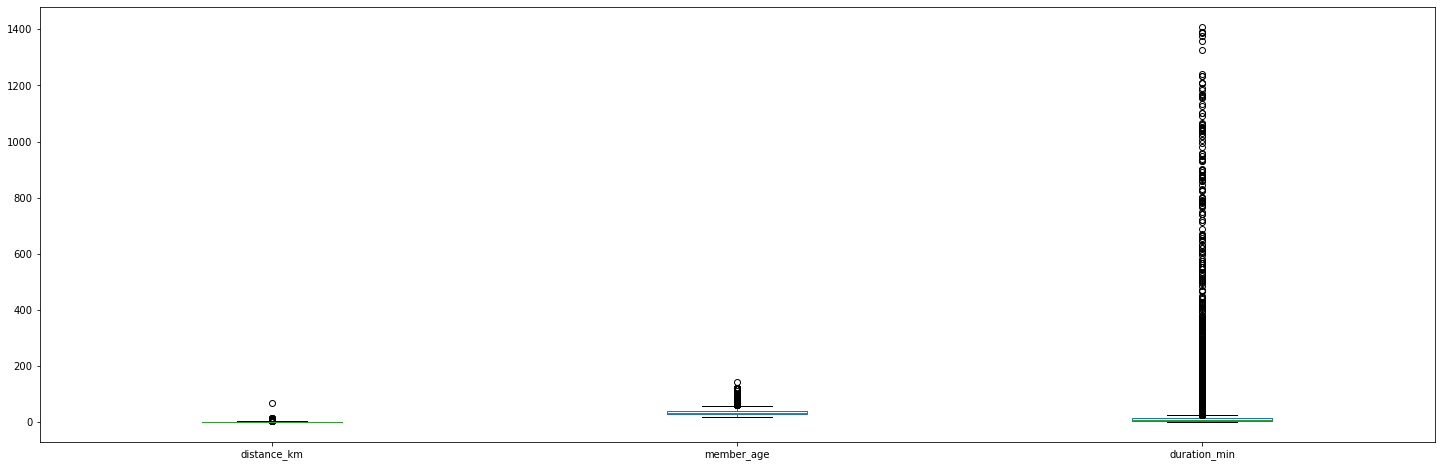

In [92]:
#check outliers by boxplot
df_bike.plot.box(sharey=False,figsize=(25,8))

In [93]:
#function to detect outliers in data
def detect_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [25, 75])
 
    # compute IRQ
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
 
    return outliers

#get the min value of outliers
print(f'duration_min : min value of outliers {min(detect_outlier((df_bike.duration_min)))}')
print(f'member_age : min value of outliers {min(detect_outlier((df_bike.member_age)))}')
print(f'distance_km : min value of outliers {min(detect_outlier((df_bike.distance_km)))}')

duration_min : min value of outliers 25
member_age : min value of outliers 59
distance_km : min value of outliers 4.197528928610675


In [94]:
#check percentage with zero distance
zero_distance = len(df_bike[df_bike.distance_km == 0]) + len(df_bike[df_bike.distance_km > 4])/ len(df_bike)
print(f'trips with zero distance and more than 4km : {zero_distance*100:.2f}%.')
#check the percentage of ages > 60
abnormal_ages = len(df_bike[df_bike.member_age >= 60]) / len(df_bike)
print(f'users with ages > 60 : {abnormal_ages*100:.2f}%.')
#check the percentage of trips with more than 25 min
long_trips = len(df_bike[df_bike.duration_min > 25]) / len(df_bike)
print(f'trips with more than 23 min : {long_trips*100:.2f}%.')

trips with zero distance and more than 4km : 345803.86%.
users with ages > 60 : 3.30%.
trips didn't end in the same day: 0.00%.
trips with more than 23 min : 4.79%.


In [95]:
#drop rows with ouliers values values 
# drop index with with distance = 0
df_bike.drop(df_bike.index[df_bike.distance_km == 0 ] ,inplace=True)
# drop outliers index with with distance > 4 km
df_bike.drop(df_bike.index[df_bike.distance_km > 4 ] ,inplace=True)
# drop outliers index with age >= 60 years
df_bike.drop(df_bike.index[df_bike['member_age'] >= 60],inplace=True)
# drop outliers index with with duration > 23 min
df_bike.drop(df_bike.index[df_bike.duration_min > 23],inplace=True)

In [96]:
#check changes
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153233 entries, 6 to 183411
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   start_time               153233 non-null  datetime64[ns]
 1   end_time                 153233 non-null  datetime64[ns]
 2   start_station_name       153233 non-null  object        
 3   end_station_name         153233 non-null  object        
 4   user_type                153233 non-null  object        
 5   member_gender            153233 non-null  object        
 6   bike_share_for_all_trip  153233 non-null  object        
 7   distance_km              153233 non-null  float64       
 8   member_age               153233 non-null  Int64         
 9   duration_min             153233 non-null  int32         
 10  trip_date                153233 non-null  object        
 11  trip_time                153233 non-null  object        
 12  trip_day        

In [97]:
#check descriptive statistics for dataset after cleaning
df_bike.describe()

,distance_km,member_age,duration_min
count,153233.000000,153233.000000,153233.000000
mean,1.584421,35.173102,8.308856
std,0.851386,8.463872,4.674825
min,0.013307,20.000000,1.000000
25%,0.921410,29.000000,5.000000
50%,1.401670,34.000000,7.000000
75%,2.099207,40.000000,11.000000
max,3.999704,59.000000,23.000000


## Univariate Exploration


- lets explore the individual variables which help us at our analysis

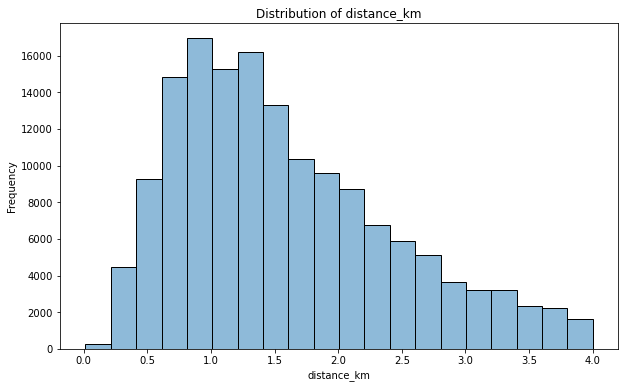

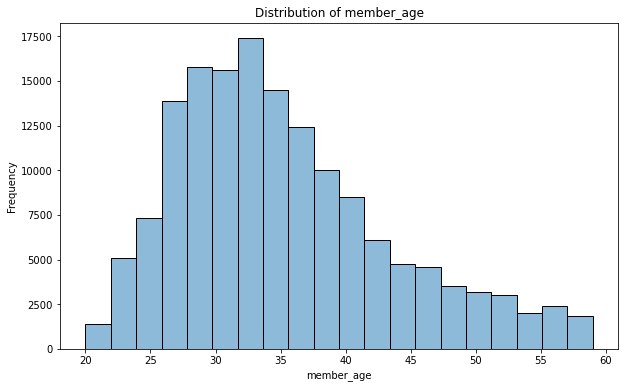

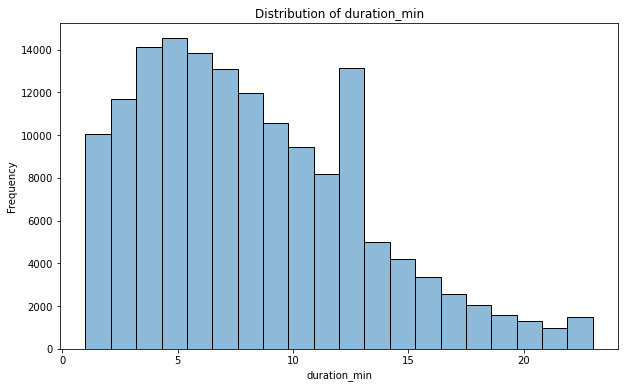

In [113]:
#check the distribution of numerical columns
for column in df_bike[['distance_km','member_age', 'duration_min']]:
    plt.figure(figsize=(10,6))
    sns.histplot(df_bike[column],bins=20 ,alpha=0.5)
    plt.ylabel('Frequency')
    plt.xlabel(column)
    plt.title('Distribution of ' +column)
    plt.show()

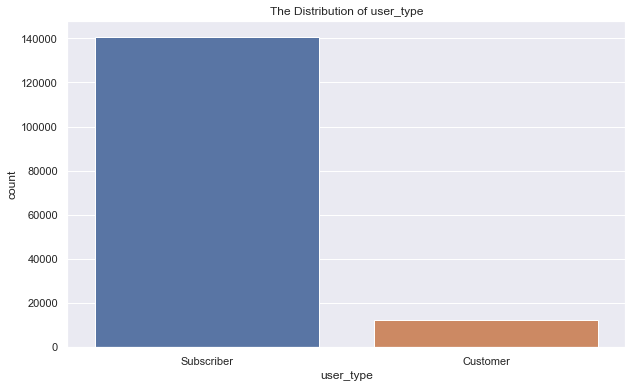

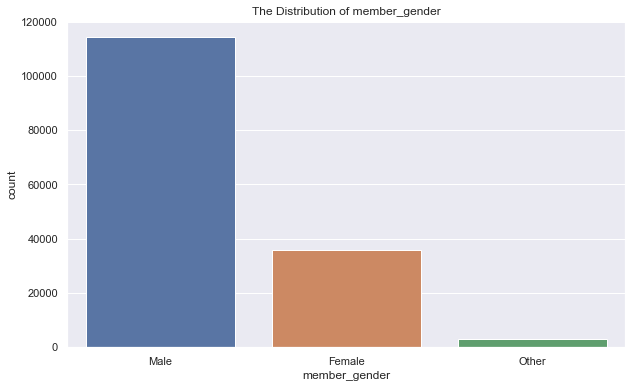

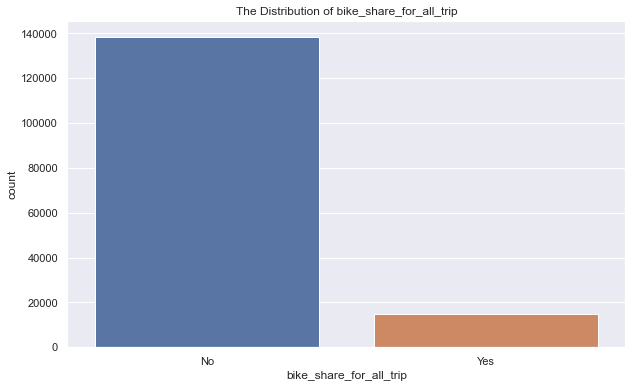

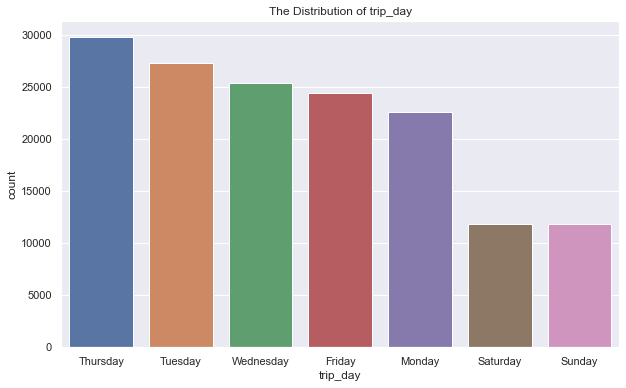

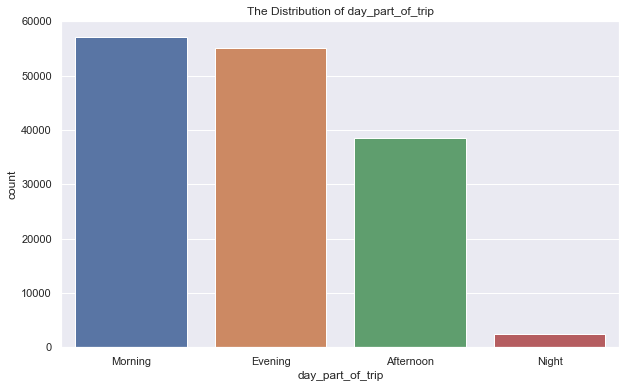

In [144]:
#the distribution of categ columns 
for column in df_bike[['user_type', 'member_gender', 'bike_share_for_all_trip','trip_day','day_part_of_trip']]:
    plt.figure(figsize = [10, 6])
    sns.countplot(df_bike[column],order = df_bike[column].value_counts().index);
    plt.title('The Distribution of '+column);
    plt.show()


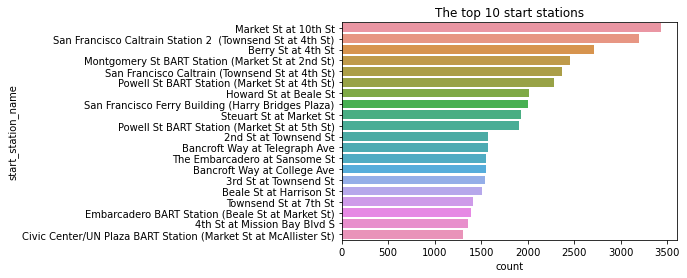

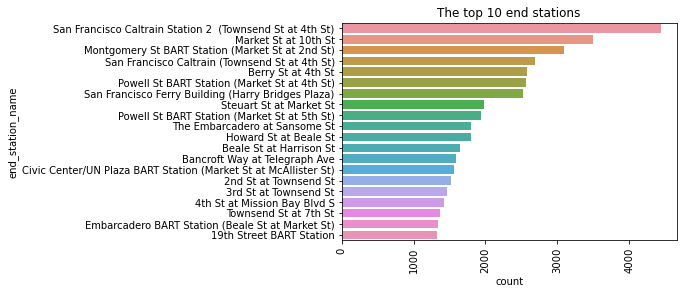

In [210]:
#the distribution of start station 
freq = df_bike['start_station_name'].value_counts()[0:20]
order = freq.index
sns.countplot(data=df_bike, y='start_station_name', order=order);
plt.title("The top 10 start stations");
plt.show()

#the distribution of end station
freq = df_bike['end_station_name'].value_counts()[0:20]
order = freq.index
sns.countplot(data=df_bike, y='end_station_name', order=order);
plt.xticks(rotation=90);
plt.title("The top 10 end stations");
plt.show()



### Bivariate Exploration


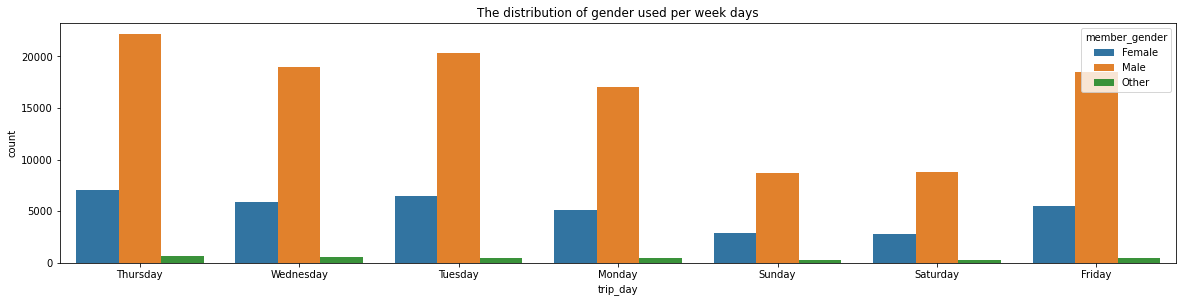

In [129]:
#distrbution of member gender and trip_day
plt.figure(figsize = [20, 15])
plt.subplot(3, 1, 1)
sns.countplot(data = df_bike, x = 'trip_day', hue = 'member_gender');
plt.title("The distribution of gender used per week days");
plt.show()

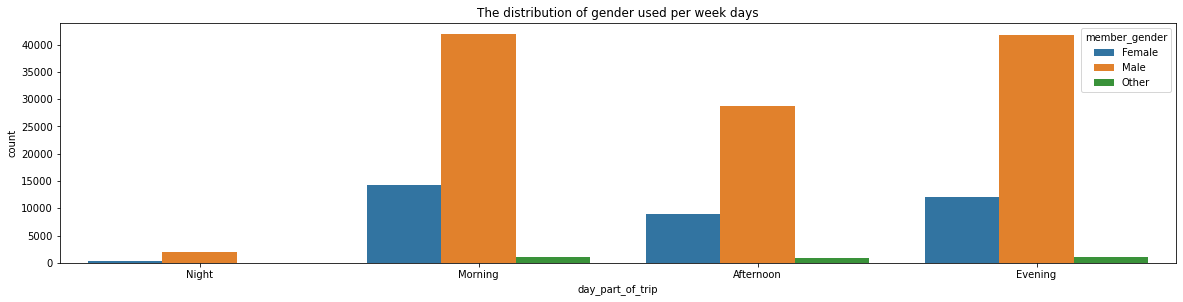

In [131]:
#distrbution of member gender and duration of trip
plt.figure(figsize = [20, 15])
plt.subplot(3, 1, 1)
sns.countplot(data = df_bike, x = 'day_part_of_trip', hue = 'member_gender');
plt.title("The distribution of gender used per week days");
plt.show()


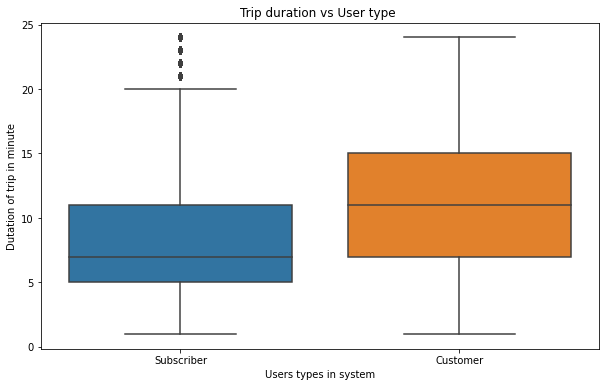

In [227]:
#distrbution of member gender and duration of trip
plt.figure(figsize=[10,6])
sns.boxplot(data=df_bike, x='user_type', y='duration_min')
plt.ylabel('Dutation of trip in minute');
plt.xlabel('Users types in system');
plt.title("Trip duration vs User type ");


- more subscriber have short trips than customers

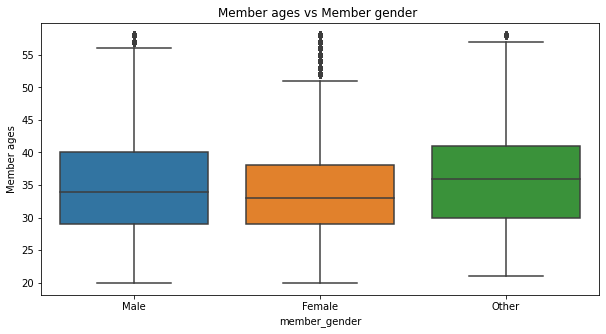

In [228]:
#distrbution of member gender and ages
plt.figure(figsize = [10, 5])
sns.boxplot(data=df_bike, x='member_gender', y='member_age')
plt.xticks(rotation=0);
plt.ylabel('Member ages');
plt.title("Member ages vs Member gender ");


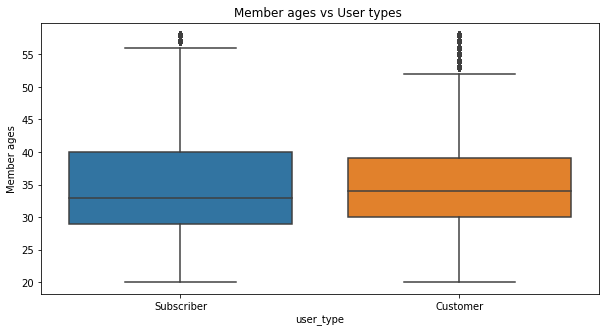

In [229]:
#distrbution of user_type and ages
plt.figure(figsize = [10, 5])
sns.boxplot(data=df_bike, x='user_type', y='member_age')
plt.xticks(rotation=0);
plt.ylabel('Member ages');
plt.title("Member ages vs User types ");


### Multivariate Exploration
- explore more the 2 variables

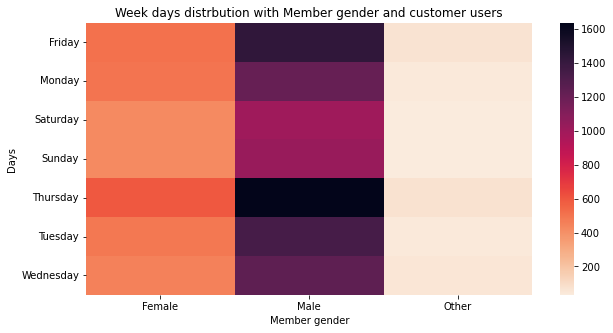

In [232]:
#Week days distrbution with Member gender and customer users
customers = df_bike.query('user_type == "Customer"')
ct_coun = customers.groupby(['trip_day', 'member_gender']).size()
ct_coun = ct_coun.reset_index(name='count')
ct_coun = ct_coun.pivot(index='trip_day', columns='member_gender', values='count')
plt.figure(figsize = [10, 5]);
sns.heatmap(ct_coun, cmap='rocket_r');
plt.xlabel('Member gender');
plt.ylabel('Days');
plt.title("Week days distrbution with Member gender and customer users");


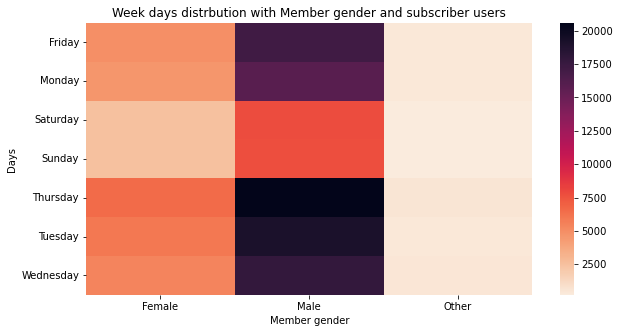

In [233]:
#Week days distrbution with Member gender and subscriber users
subscribers = df_bike.query('user_type == "Subscriber"')
st_coun = subscribers.groupby(['trip_day', 'member_gender']).size()
st_coun = st_coun.reset_index(name='count')
st_coun = st_coun.pivot(index='trip_day', columns='member_gender', values='count')
plt.figure(figsize = [10, 5]);
sns.heatmap(st_coun, cmap='rocket_r');
plt.title("Week days distrbution with Member gender and subscriber users");
plt.xlabel('Member gender');
plt.ylabel('Days');